# Physics-informed neural networks (PINNs): an introductory crash-course

By Ben Moseley, 2022

This workshop builds upon my blog post on PINNs: https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/. 

Read the seminal PINN papers [here](https://ieeexplore.ieee.org/document/712178) and [here](https://www.sciencedirect.com/science/article/pii/S0021999118307125).


## Workshop goals

By the end of this workshop, you should be able to:
- code a PINN from scratch in PyTorch
- understand the different types of scientific tasks PINNs can be used for
- understand in more detail how PINNs are trained and how to improve their convergence


## Task overview

We will be coding a PINN from scratch in PyTorch and using it solve simulation and inversion tasks related to the damped harmonic oscillator.


## Problem overview

We are going to use a PINN to solve problems related to the **damped harmonic oscillator**:

<img src="oscillator.gif" width="500">

We are interested in modelling the displacement of the mass on a spring (green box) over time.

This is a canonical physics problem, where the displacement, $u(t)$, of the oscillator as a function of time can be described by the following differential equation:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

We will focus on solving the problem in the **under-damped state**, i.e. where the oscillation is slowly damped by friction (as displayed in the animation above). 

Mathematically, this occurs when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Furthermore, we consider the following initial conditions of the system:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

For this particular case, the exact solution is known and given by:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$



For a more detailed mathematical description of the harmonic oscillator, check out this blog post: https://beltoforion.de/en/harmonic_oscillator/.

Here you can see an overview of the 2 dimensional space (t, mu):

<img src="excalidraw1.JPG" width="750">

## Step 1: Definition and initialization

In [1]:
### Import all what you need:
import torch
import torch.nn as nn
from torchsummary import summary # https://pypi.org/project/torch-summary/
import torchinfo 

import numpy as np

import matplotlib.pyplot as plt

import time

In [2]:
# Pseudorandom number generator:
torch.manual_seed(123)

In [3]:
#Definition of the physical constants and hyperparameters:
mass = 1
d, w0 = 2, 20
mu, k = 2*d, w0**2            # Este mu NO se utiliza!!!!!
learning_rate =  1e-3         # learning rate
lambda1, lambda2 = 1e-3, 1e-4 # loss term hyperparameters
epochs = 20001

### Initial, training and test points generation:

#### Initial condition 1: generation of initial points:
$$ u(t=0, \mu) = 1
$$


In [4]:
#### Generation of t and mu initial points (Initial condition 1) 
point_resolution = 40

ic1_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)],-1)
ic1_scope = torch.ones_like(ic1_t_mu[:,0:1]).requires_grad_(True)

#print(f"Initial condition 1: \n \t [t, mu]: \n{ic1_t_mu}")
#print(f"\n Initial condition 1: \n \t u(t=0, mu) = 1: \n {ic1_scope}")
#print(f"\n Shapes of [t, mu] and u(t=0, mu) = 1: \n\t{ic1_t_mu.shape}, {ic1_scope.shape}")

#### Initial condition 2: t and mu training points generation:
$$
\dfrac{d u}{d t}(t=0, \mu) = 0~
$$

In [5]:
ic2_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)], -1)
ic2_scope = torch.zeros_like(ic2_t_mu[:,0:1]).requires_grad_(True)

#print(f"Initial condition 2: \n \t [t, mu]: \n{ic2_t_mu}")
#print(f"\n Initial condition 2: \n \t du/dt(t=0, mu) = 0: \n\t {ic2_scope}")
#print(f"\n Shapes of [t, mu] and du/dt(t=0, mu) = 0: \n\t {ic2_t_mu.shape}, {ic2_scope.shape}")

#### Generation of physical domain training points: 

In [6]:
### Generate domain physic loss sample points:
physic_in_t_mu = [torch.linspace(1e-2,1, point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)] # Mejora: se puede utilizar torch.rand
physic_domain_t_mu = torch.stack(torch.meshgrid(*physic_in_t_mu, indexing='ij'), -1).view(-1, 2).requires_grad_(True)

#print(f" Point seed list for mesh grid domain points: \n \t {physic_in_t_mu}")
#print(f"Domain training points: \n \t: {physic_domain_t_mu}")
#print(f"Size of Domain training points: \n \t {physic_domain_t_mu.size()}")

#### Generation of testing points:

In [7]:
#### Generation of t and mu test points within the domain:
point_resolution_test = 100

# Testing points:
test_in_t_mu = [torch.linspace(0,1,point_resolution_test), torch.linspace(1,10,point_resolution_test) ]
test_domain_t_mu = torch.stack(torch.meshgrid(*test_in_t_mu, indexing='ij'), -1).view(-1, 2)

#print(f"Point seed list for mesh grid test points: \n \t \n \t: {physic_domain_t_mu}")
#print(f"Test points \n \t [t, mu]: \n \t {physic_domain_t_mu}")
#print(f"Size of the test domain points: \n \t {test_domain_t_mu.size()}")

### Exact solution:

In [8]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0             
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

In [9]:
# Example to check if it works (calculation of the exact solution):
test_mu = 5
u_exact = exact_solution(test_mu/(2*mass), w0, test_in_t_mu[0])
#u_exact.view(-1,1)
#u_exact.size()
#u_exact.numel()
#u_exact.dim()
#u_exact

In [10]:
physic_in_t_mu[0]

tensor([0.0100, 0.0354, 0.0608, 0.0862, 0.1115, 0.1369, 0.1623, 0.1877, 0.2131,
        0.2385, 0.2638, 0.2892, 0.3146, 0.3400, 0.3654, 0.3908, 0.4162, 0.4415,
        0.4669, 0.4923, 0.5177, 0.5431, 0.5685, 0.5938, 0.6192, 0.6446, 0.6700,
        0.6954, 0.7208, 0.7462, 0.7715, 0.7969, 0.8223, 0.8477, 0.8731, 0.8985,
        0.9238, 0.9492, 0.9746, 1.0000], requires_grad=True)

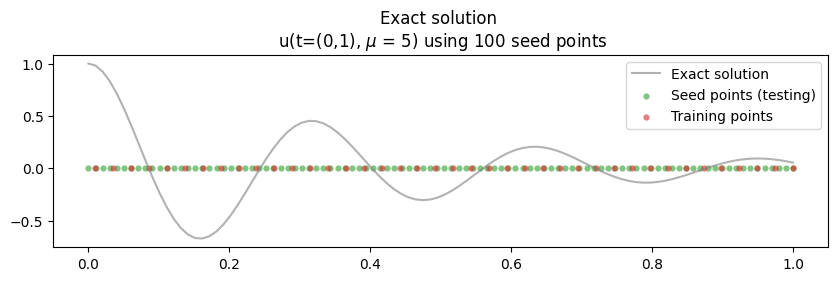

In [11]:
# Plotting the exact solution:
plt.figure(figsize=(10,2.5))
plt.plot(
        test_in_t_mu[0], 
        u_exact, 
        label="Exact solution", 
        color="tab:grey", 
        alpha=0.6)
plt.scatter(
        test_in_t_mu[0], 
        torch.zeros_like(test_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Seed points (testing)")
plt.scatter(
        physic_in_t_mu[0].detach().numpy(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:red",
        alpha=0.6,
        label= "Training points")

plt.title(f"Exact solution \n u(t=(0,1), $\mu$ = {test_mu}) using {point_resolution_test} seed points")
plt.legend()
plt.show()

## Step 2: Create Fully Connected Neural Network Class (FCNN):

In [12]:
### Definition of the Fully Connected Neural Network Class:
# Ben Moseley:
class FCN(nn.Module):
    "Defines a fully-connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### Definition of the Fully Connected Neural Network Class
# Ben Moseley and added ACTIVATION FUNCTION and INITIALIZATION

class FCN_init(nn.Module):
    "Defines a fully-connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, activation = "LeakyReLU"):#, initialization = "Xavier"):
        super().__init__()
        activation_functions = nn.ModuleDict([
                                            ["Tanh", nn.Tanh()],
                                            ["ReLU", nn.ReLU()],
                                            ["LeakyReLU", nn.LeakyReLU()],
                                            ["Sigmoid", nn.Sigmoid()],
                                            ["Softmax", nn.Softmax()],
                                            ])
      # initialization_type = nn.ModuleDict([
      #     ["Xavier", nn.init.xavier_normal_],
      #     ])
        #activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation_functions[activation]])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation_functions[activation]]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.weights_and_bias_initialization()
        #self.initialization = initialization
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

    def weights_and_bias_initialization(self):
        for module_with_layers in self.modules():
            if isinstance(module_with_layers, nn.Linear):
                #initialization_type(module_with_layers.weight)
                #nn.init.xavier_uniform_(module_with_layers.weight)
                #nn.init.constant_(module_with_layers.bias, 0)
                nn.init.kaiming_uniform_(module_with_layers.weight)
                nn.init.constant_(module_with_layers.bias, 0)

class FCN_1(nn.Module):   # inherent from nn.Module
    "Defines a standard fully-connected network in PyTorch"
    # Initialization of the neural network layers in __init__:
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()                                      
        
        # INPUT Linear function: 1x1 --> 32x1: [A](32x1)*[X](1x1) + [b](32x1)
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        
        # INPUT Non-linearity (activation function): 32x1-->32x1
        self.tangh = nn.Tanh()
        
        # OUTPUT Linear function: 32x1 --> 1x1: [A](32x1)*[X](1x1) + [b](32x1)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    
    def forward(self, input):
        # INPUT Linear function:
        hidden = self.fc_in(input)

        # HIDDEN Non-linearity
        hidden = self.tangh(hidden)

        # OUTPUT Linear function
        output = self.fc_out(hidden)
        
        return output

## STEP 3: Instantiate the Model Class

In [13]:
model = FCN(2,1,64,4)
#print(model.parameters)
#print(model.state_dict())

In [14]:
model_init = FCN_init(2,1,64,4, activation= "LeakyReLU")
model_init.parameters

<bound method Module.parameters of FCN_init(
  (fcs): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fch): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (fce): Linear(in_features=64, out_features=1, bias=True)
)>

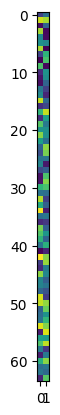

In [15]:
plt.imshow(model_init.state_dict()["fcs.0.weight"])

In [16]:
model_fcn1 = FCN_1(2,8,1)
print(model_fcn1.parameters)
print(model_fcn1.state_dict().keys())

<bound method Module.parameters of FCN_1(
  (fc_in): Linear(in_features=2, out_features=8, bias=True)
  (tangh): Tanh()
  (fc_out): Linear(in_features=8, out_features=1, bias=True)
)>
odict_keys(['fc_in.weight', 'fc_in.bias', 'fc_out.weight', 'fc_out.bias'])


### Checking the model using test points and a constant mu value:

In [17]:
test_mu = 5
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
#print(f" Point seed list for mesh grid domain points: \n \t {test_in_t_constant_mu}")
#print(f"Size of Domain training points: \n \t {test_in_t_constant_mu.size()}")

In [18]:
# NO es necesario porque se mantiene constante mu
#test_domain_t_constant_mu = torch.stack(torch.meshgrid(*test_in_t_constant_mu, indexing='ij'), -1).view(-1, 2)
#test_domain_t_constant_mu.size()
#print(f"Domain training points: \n \t: {test_domain_t_constant_mu}")

In [19]:
test_predicted = model(test_in_t_constant_mu)
test_predicted.size()

torch.Size([100, 1])

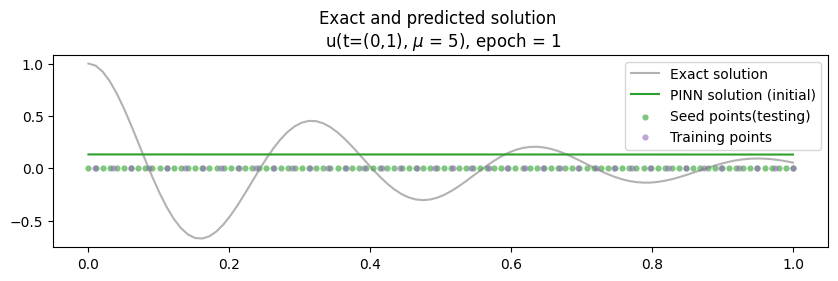

In [20]:
plt.figure(figsize=(10,2.5))
plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
)
plt.plot(test_in_t_mu[0], 
                 test_predicted[:,0].detach().numpy(), 
                 label="PINN solution (initial)", 
                 color="tab:green"
)
plt.scatter(
        test_in_t_mu[0], 
        torch.zeros_like(test_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Seed points(testing)"
)
plt.scatter(
        physic_in_t_mu[0].detach().numpy(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:purple",
        alpha=0.6,
        label= "Training points"
)
plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), epoch = 1")
plt.legend()
plt.show()

In [21]:
#test_predicted

In [22]:
test_predicted_init = model_init(test_in_t_constant_mu)

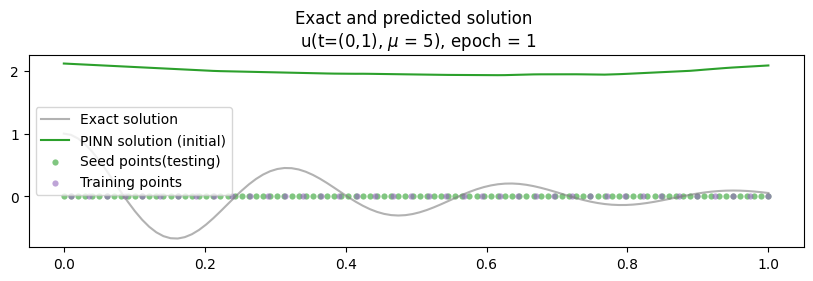

In [23]:
plt.figure(figsize=(10,2.5))
plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
)
plt.plot(test_in_t_mu[0], 
                 test_predicted_init[:,0].detach().numpy(), 
                 label="PINN solution (initial)", 
                 color="tab:green"
)
plt.scatter(
        test_in_t_mu[0], 
        torch.zeros_like(test_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Seed points(testing)"
)
plt.scatter(
        physic_in_t_mu[0].detach().numpy(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:purple",
        alpha=0.6,
        label= "Training points"
)
plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), epoch = 1")
plt.legend()
plt.show()

In [25]:
#test_predicted_init

## STEP 4: Selection of the Optimizer

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
#optimizer

## STEP 5: Training the PINN:

Decomposition of the loss terms: 
 loss(1.0260381698608398) = loss1(0.7631644010543823) + 0.001 * loss2(8.031311153899878e-05) + 0.0001 * loss3(2628.73779296875)


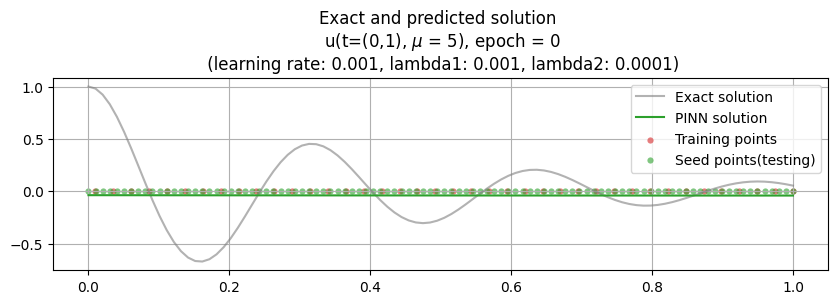

Decomposition of the loss terms: 
 loss(0.054425060749053955) = loss1(0.0048806509003043175) + 0.001 * loss2(0.10006256401538849) + 0.0001 * loss3(494.4434814453125)


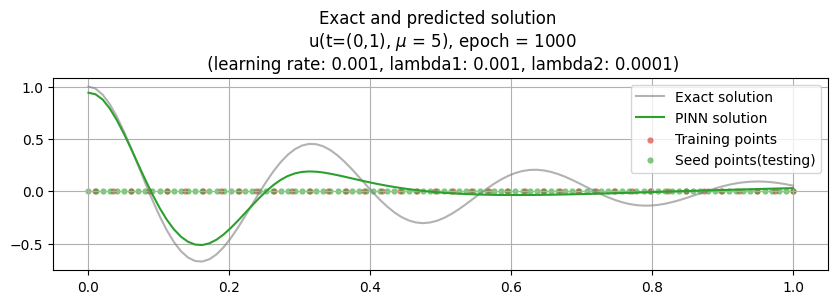

Decomposition of the loss terms: 
 loss(0.0251548383384943) = loss1(0.0016449198592454195) + 0.001 * loss2(0.028727203607559204) + 0.0001 * loss3(234.8119354248047)


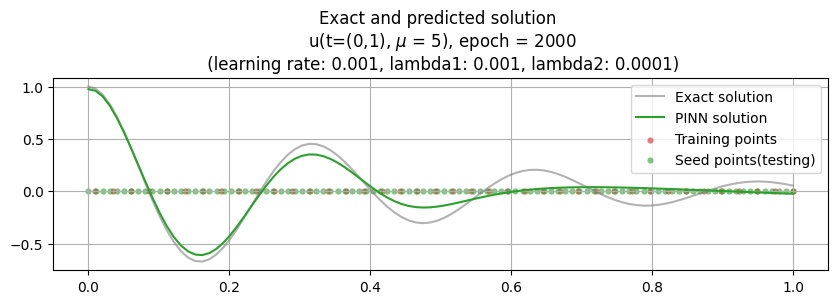

Decomposition of the loss terms: 
 loss(0.019522512331604958) = loss1(0.0009738141670823097) + 0.001 * loss2(0.008094669319689274) + 0.0001 * loss3(185.4060516357422)


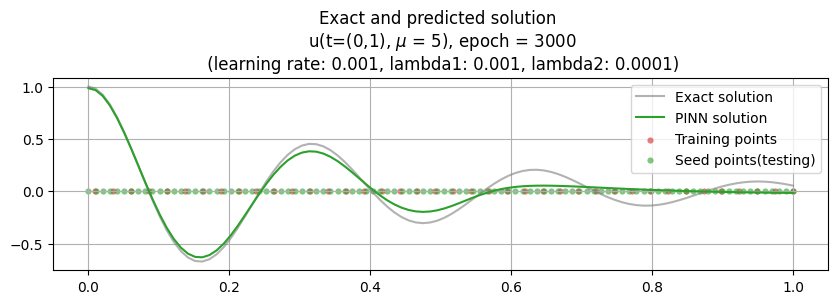

Decomposition of the loss terms: 
 loss(0.015116382390260696) = loss1(0.0007335148984566331) + 0.001 * loss2(0.003625995945185423) + 0.0001 * loss3(143.79241943359375)


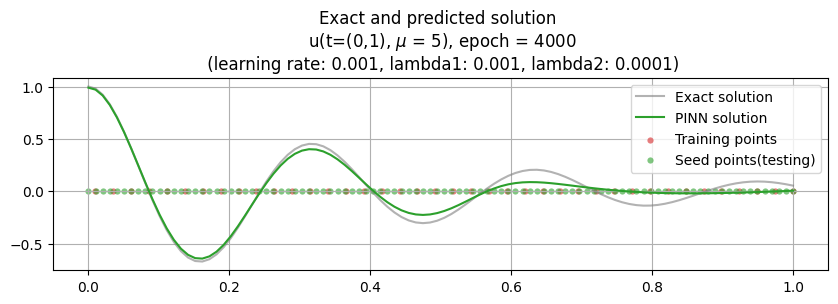

Decomposition of the loss terms: 
 loss(0.012764214538037777) = loss1(0.0005425844574347138) + 0.001 * loss2(0.0018400553381070495) + 0.0001 * loss3(122.19790649414062)


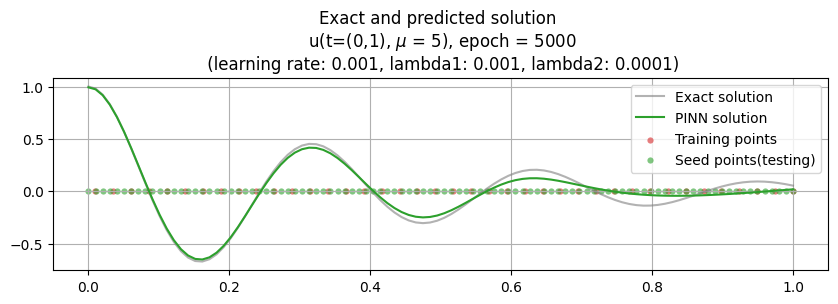

Decomposition of the loss terms: 
 loss(0.01145146880298853) = loss1(0.00044361292384564877) + 0.001 * loss2(0.004592549987137318) + 0.0001 * loss3(110.03263854980469)


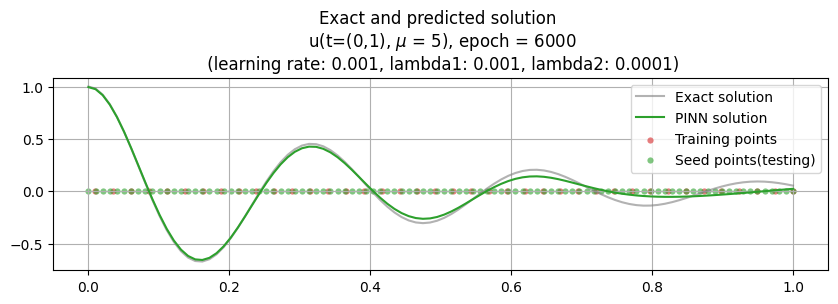

Decomposition of the loss terms: 
 loss(0.010446191765367985) = loss1(0.0004060097853653133) + 0.001 * loss2(0.008375919423997402) + 0.0001 * loss3(100.31806945800781)


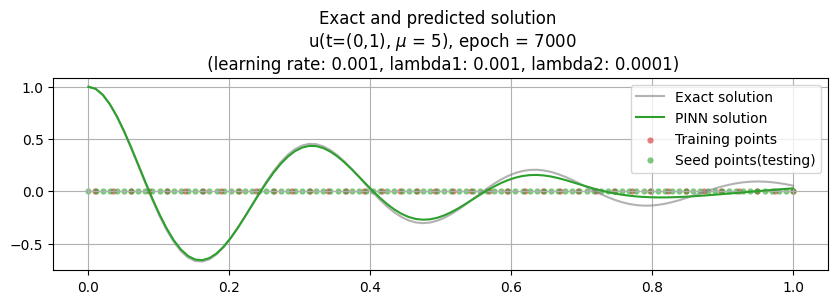

Decomposition of the loss terms: 
 loss(0.0093744657933712) = loss1(0.0003385073214303702) + 0.001 * loss2(0.0006742813857272267) + 0.0001 * loss3(90.35285186767578)


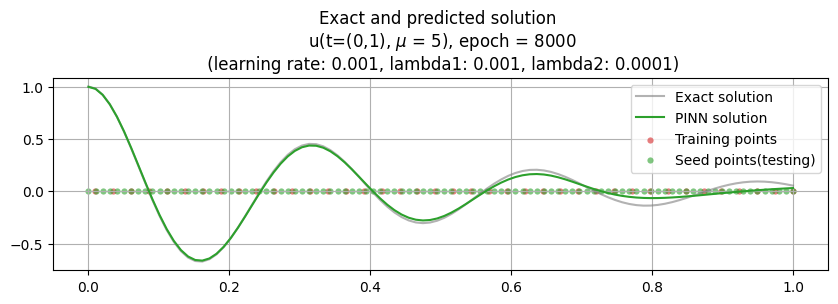

Decomposition of the loss terms: 
 loss(0.006379920989274979) = loss1(0.0002535195671953261) + 0.001 * loss2(0.000815191597212106) + 0.0001 * loss3(61.255863189697266)


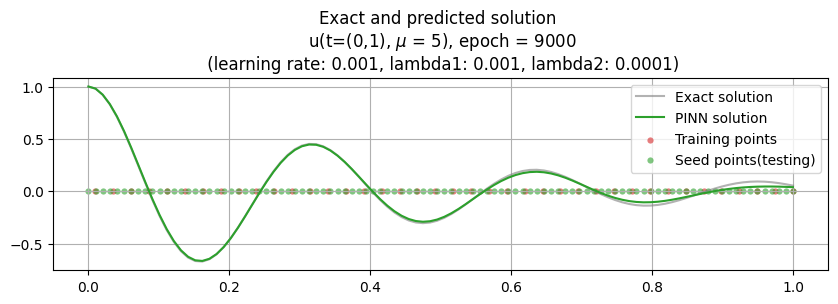

Decomposition of the loss terms: 
 loss(0.003914560191333294) = loss1(0.00015914306277409196) + 0.001 * loss2(0.004303941037505865) + 0.0001 * loss3(37.511131286621094)


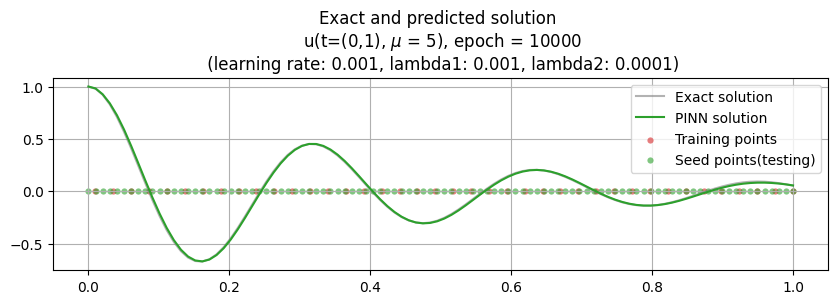

Decomposition of the loss terms: 
 loss(0.005986669100821018) = loss1(0.00015503870963584632) + 0.001 * loss2(0.0012370696058496833) + 0.0001 * loss3(58.303932189941406)


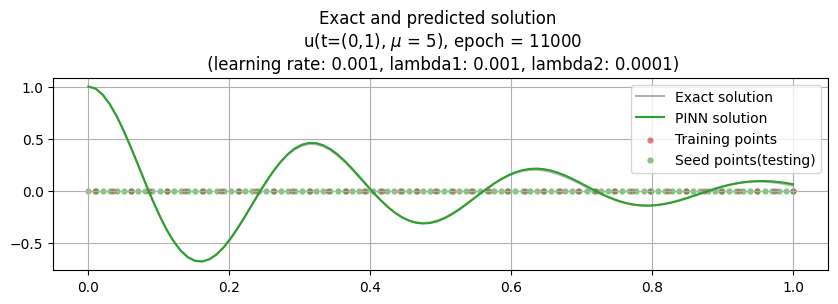

Decomposition of the loss terms: 
 loss(0.0019629057496786118) = loss1(9.090105595532805e-05) + 0.001 * loss2(0.0008086342131718993) + 0.0001 * loss3(18.71196174621582)


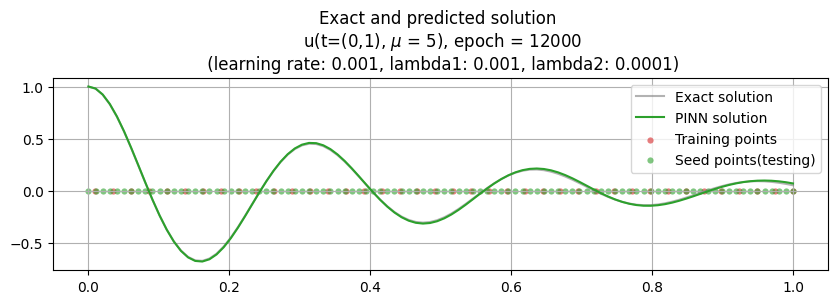

Decomposition of the loss terms: 
 loss(0.0013032682472839952) = loss1(6.014034079271369e-05) + 0.001 * loss2(0.0007734279497526586) + 0.0001 * loss3(12.423544883728027)


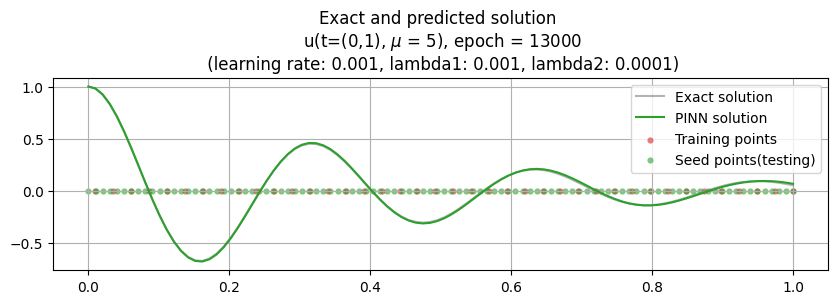

Decomposition of the loss terms: 
 loss(0.000845914357341826) = loss1(4.084152897121385e-05) + 0.001 * loss2(0.0006029849755577743) + 0.0001 * loss3(8.044698715209961)


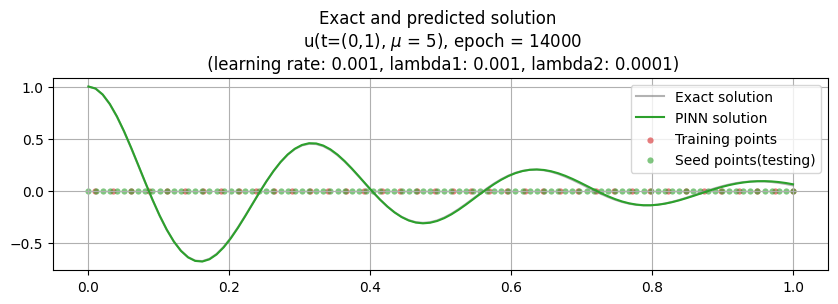

Decomposition of the loss terms: 
 loss(0.0009674860630184412) = loss1(7.851859845686704e-05) + 0.001 * loss2(0.09604291617870331) + 0.0001 * loss3(7.929245471954346)


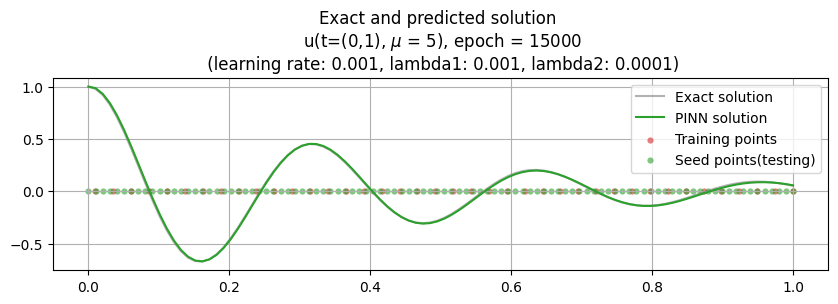

Decomposition of the loss terms: 
 loss(0.0004144326376263052) = loss1(1.939506910275668e-05) + 0.001 * loss2(0.0004205404839012772) + 0.0001 * loss3(3.9461705684661865)


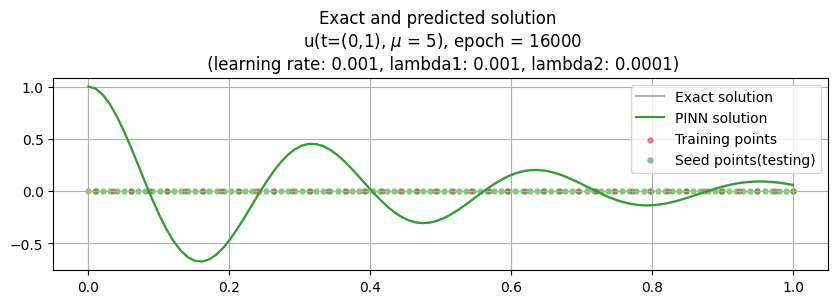

Decomposition of the loss terms: 
 loss(0.00030508142663165927) = loss1(1.5062051716085989e-05) + 0.001 * loss2(0.0008004127885214984) + 0.0001 * loss3(2.8921897411346436)


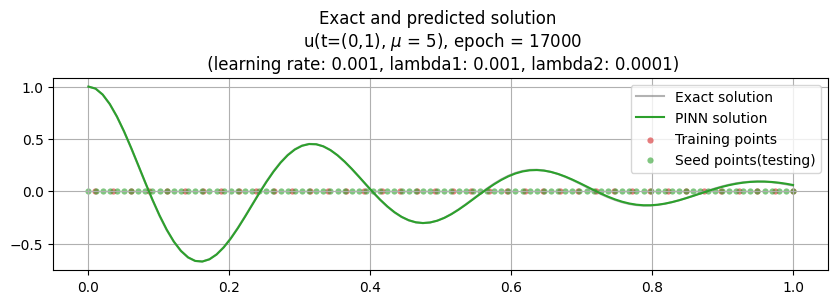

Decomposition of the loss terms: 
 loss(0.00023507642617914826) = loss1(1.0233918146695942e-05) + 0.001 * loss2(0.0005026852013543248) + 0.0001 * loss3(2.2433981895446777)


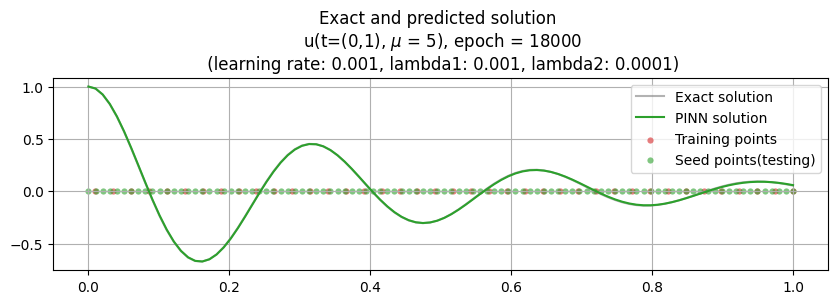

Decomposition of the loss terms: 
 loss(0.0003367053286638111) = loss1(1.6537660485482775e-05) + 0.001 * loss2(0.0005463096895255148) + 0.0001 * loss3(3.196213483810425)


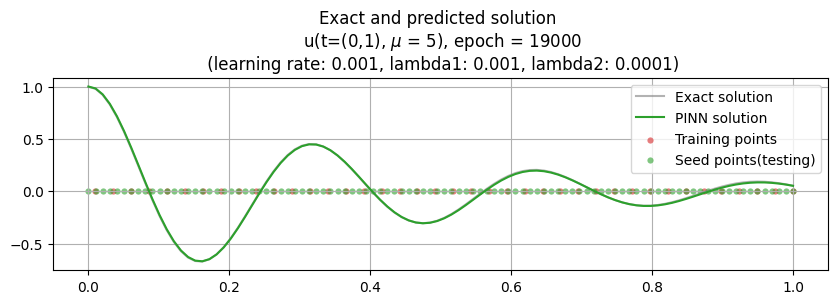

Decomposition of the loss terms: 
 loss(0.0001512909511802718) = loss1(6.01731790084159e-06) + 0.001 * loss2(0.0023071810137480497) + 0.0001 * loss3(1.4296646118164062)


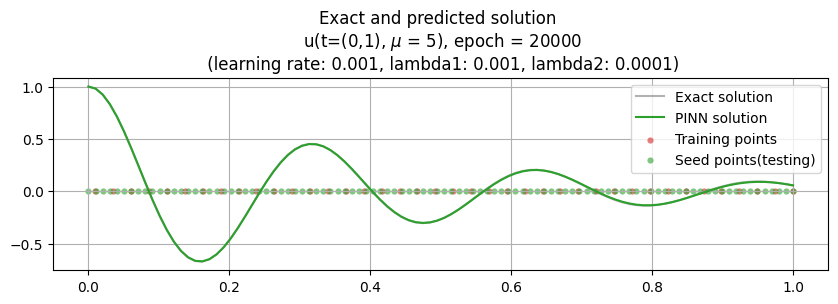

Training elapsed time (s): 243.62090182304382


In [27]:
epochs = 20001
start = time.time()
# Creation of the variables loss1_history, loss2_history and loss3_history for printing the evolution of the contribution of every loss term:
loss_ic1_history = []
loss_ic2_history = []
loss_differential_equation_history = []

for i in range(epochs):
    optimizer.zero_grad()

    # compute initial condition 1 loss:
    ic1_predicted= model(ic1_t_mu)
    loss_ic1 = torch.mean((ic1_predicted - ic1_scope)**2)
    loss_ic1_history.append(loss_ic1.item())


    # compute initial condition 2 loss:
    du_dtdmu_initial = torch.autograd.grad(outputs = ic1_predicted, inputs = ic1_t_mu, grad_outputs= torch.ones_like(ic1_predicted), create_graph= True)[0]
    ic2_du_dt, ic2_du_dmu = du_dtdmu_initial[:, 0:1], du_dtdmu_initial[:,1:2]
    loss_ic2 = torch.mean((ic2_du_dt- ic2_scope)**2)
    loss_ic2_history.append(loss_ic2.item())

    # compute physic loss:
    physic_domain_predicted = model(physic_domain_t_mu)
    physic_domain_du_dtdmu = torch.autograd.grad(outputs = physic_domain_predicted, inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_predicted), create_graph= True)[0]
    physic_domain_d2u_d2t_d2mu = torch.autograd.grad(outputs = physic_domain_du_dtdmu[:,0:1], inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_du_dtdmu[:,0:1]), create_graph= True)[0]
    loss_differential_equation = torch.mean( (physic_domain_d2u_d2t_d2mu[:,0:1] + physic_domain_t_mu[:,1:2] * physic_domain_du_dtdmu[:,0:1] + k * physic_domain_predicted )**2)
    loss_differential_equation_history.append(loss_differential_equation.item())
    
    loss = loss_ic1 + lambda1 * loss_ic2 + lambda2 * loss_differential_equation
    
    loss.backward()
    optimizer.step()
    
    
    if i%1000 == 0:
        print(f'Decomposition of the loss terms: \n loss({loss}) = loss1({loss_ic1}) + {lambda1} * loss2({loss_ic2}) + {lambda2} * loss3({loss_differential_equation})')
        
        test_predicted = model(test_in_t_constant_mu)
        
        plt.figure(figsize=(10,2.5))
        plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
        )
        plt.plot(
                test_in_t_mu[0], 
                test_predicted[:,0].detach().numpy(), 
                label="PINN solution", 
                color="tab:green"
        )
        plt.scatter(
                    physic_in_t_mu[0].detach().numpy(), 
                    torch.zeros_like(physic_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:red",
                    alpha=0.6,
                    label= "Training points"
        )
        plt.scatter(
                    test_in_t_mu[0], 
                    torch.zeros_like(test_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:green",
                    alpha=0.6,
                    label= "Seed points(testing)"
        )
        plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), epoch = {i} \n (learning rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})")
        plt.grid()
        plt.legend()
        plt.show()
end = time.time()
execution_time = (end - start)
print(f"Training elapsed time (s): {execution_time}")
        

### Investigation of the loss terms:

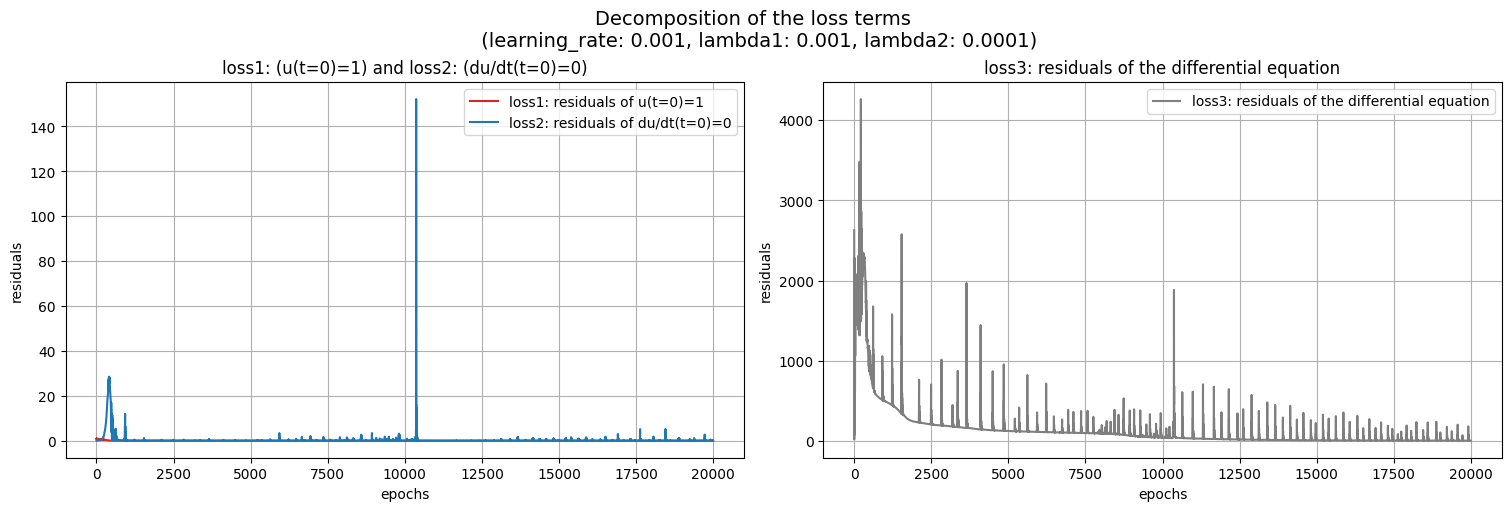

In [28]:
# plot the contribution of every loss term (loss1, loss2 and loss3)
fig, (loss1_2, loss3) = plt.subplots(1,2, layout = 'constrained', sharex = True, figsize = (15,5))
fig.suptitle(f"Decomposition of the loss terms \n (learning_rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})", fontsize = 14)

loss1_2.plot(loss_ic1_history, label = "loss1: residuals of u(t=0)=1", color = "tab:red")
loss1_2.plot(loss_ic2_history, label = "loss2: residuals of du/dt(t=0)=0", color = "tab:blue")
loss1_2.set_title("loss1: (u(t=0)=1) and loss2: (du/dt(t=0)=0)")
loss1_2.set_xlabel("epochs")
loss1_2.set_ylabel("residuals")
loss1_2.grid()
loss1_2.legend()

loss3.plot(loss_differential_equation_history, label= "loss3: residuals of the differential equation", color = "tab:grey")
loss3.set_title("loss3: residuals of the differential equation")
loss3.set_xlabel("epochs")
loss3.set_ylabel("residuals")
loss3.legend()
loss3.grid()

### Inference:

In [29]:
test_mu = 10
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
test_in_t_constant_mu.size()

torch.Size([100, 2])

In [30]:
test_predicted = model(test_in_t_constant_mu)

In [31]:
u_exact = exact_solution(test_mu/(2*mass), w0, test_in_t_mu[0])

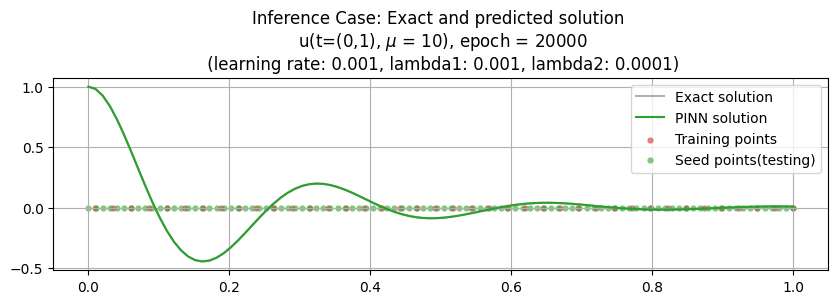

In [32]:
#u_test = pinn(test_t_frict_coeff_total).detach().cpu()
plt.figure(figsize=(10,2.5))

plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6)
plt.plot(test_in_t_mu[0], 
                 test_predicted[:,0].detach().numpy(), 
                 label="PINN solution", 
                 color="tab:green")
plt.scatter(
            physic_in_t_mu[0].detach().numpy(), 
            torch.zeros_like(physic_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:red",
            alpha=0.6,
            label= "Training points")
plt.scatter(
            test_in_t_mu[0], 
            torch.zeros_like(test_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:green",
            alpha=0.6,
            label= "Seed points(testing)")
plt.title(f"Inference Case: Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), epoch = {i} \n (learning rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})")
plt.grid()
plt.legend()
plt.show()

### Training using a different initialization: 

Check for a fixed value f mu:

In [33]:
test_mu = 5
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
u_exact = exact_solution(test_mu/(2*mass), w0, test_in_t_mu[0])
#print(f" Point seed list for mesh grid domain points: \n \t {test_in_t_constant_mu}")
#print(f"Size of Domain training points: \n \t {test_in_t_constant_mu.size()}")b

In [34]:
test_predicted_init = model_init(test_in_t_constant_mu)
#print(test_predicted)

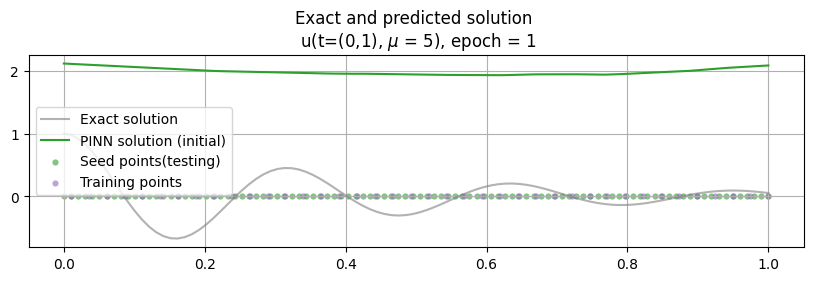

In [35]:
plt.figure(figsize=(10,2.5))
plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
)
plt.plot(test_in_t_mu[0], 
                 test_predicted_init[:,0].detach().numpy(), 
                 label="PINN solution (initial)", 
                 color="tab:green"
)
plt.scatter(
        test_in_t_mu[0], 
        torch.zeros_like(test_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Seed points(testing)"
)
plt.scatter(
        physic_in_t_mu[0].detach().numpy(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:purple",
        alpha=0.6,
        label= "Training points"
)
plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), epoch = 1")
plt.grid()
plt.legend()
plt.show()

In [36]:
ic1_t_mu
physic_domain_t_mu
loss_ic1

tensor(6.0173e-06, grad_fn=<MeanBackward0>)

Decomposition of the loss terms: 
 loss(98.52333068847656) = loss1(3.0363786220550537) + 0.001 * loss2(0.30679851770401) + 0.0001 * loss3(954866.5)


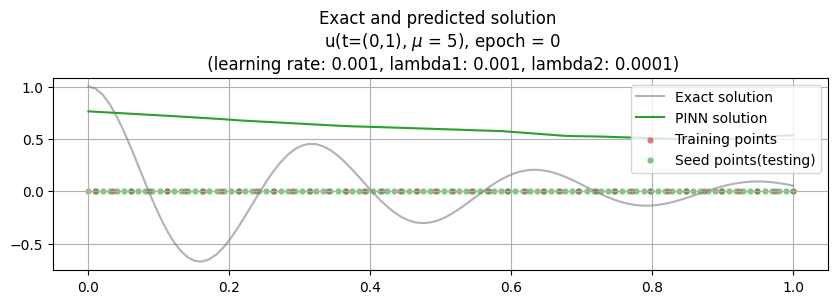

Decomposition of the loss terms: 
 loss(0.37399744987487793) = loss1(0.20425817370414734) + 0.001 * loss2(18.857013702392578) + 0.0001 * loss3(1508.822509765625)


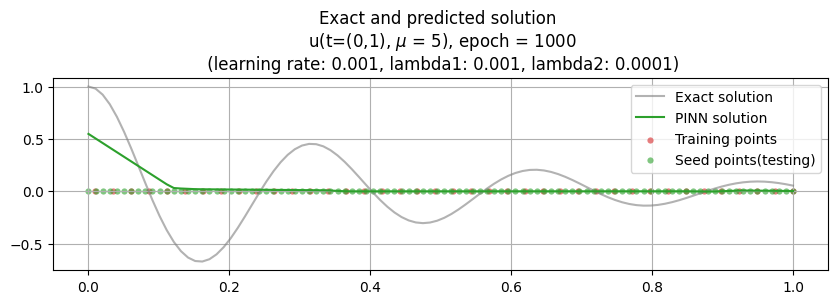

Decomposition of the loss terms: 
 loss(0.29481351375579834) = loss1(0.08393613994121552) + 0.001 * loss2(87.29768371582031) + 0.0001 * loss3(1235.7969970703125)


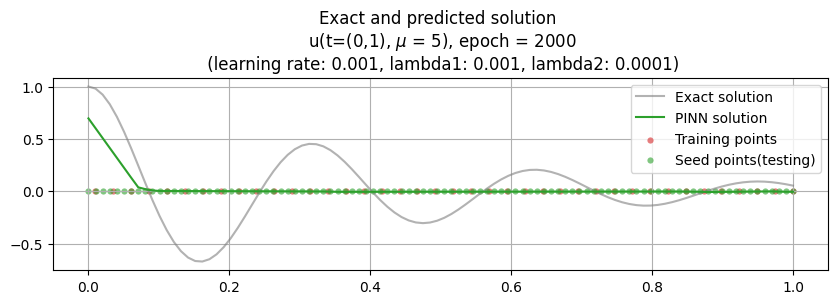

KeyboardInterrupt: 

In [37]:
optimizer_init = torch.optim.Adam(model_init.parameters(), lr= learning_rate)
epochs = 10001
start = time.time()
# Creation of the variables loss1_history, loss2_history and loss3_history for printing the evolution of the contribution of every loss term:

loss_ic1_history = []
loss_ic2_history = []
loss_differential_equation_history = []

for i in range(epochs):
    optimizer_init.zero_grad()

    # compute initial condition 1 loss:
    ic1_predicted= model_init(ic1_t_mu)
    loss_ic1 = torch.mean((ic1_predicted - ic1_scope)**2)
    loss_ic1_history.append(loss_ic1.item())


    # compute initial condition 2 loss:
    du_dtdmu_initial = torch.autograd.grad(outputs = ic1_predicted, inputs = ic1_t_mu, grad_outputs= torch.ones_like(ic1_predicted), create_graph= True)[0]
    ic2_du_dt, ic2_du_dmu = du_dtdmu_initial[:, 0:1], du_dtdmu_initial[:,1:2]
    loss_ic2 = torch.mean((ic2_du_dt- ic2_scope)**2)
    loss_ic2_history.append(loss_ic2.item())

    # compute physic loss:
    physic_domain_predicted = model_init(physic_domain_t_mu)
    physic_domain_du_dtdmu = torch.autograd.grad(outputs = physic_domain_predicted, inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_predicted), create_graph= True)[0]
    physic_domain_d2u_d2t_d2mu = torch.autograd.grad(outputs = physic_domain_du_dtdmu[:,0:1], inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_du_dtdmu[:,0:1]), create_graph= True)[0]
    loss_differential_equation = torch.mean( (physic_domain_d2u_d2t_d2mu[:,0:1] + physic_domain_t_mu[:,1:2] * physic_domain_du_dtdmu[:,0:1] + k * physic_domain_predicted )**2)
    loss_differential_equation_history.append(loss_differential_equation.item())
    
    loss = loss_ic1 + lambda1 * loss_ic2 + lambda2 * loss_differential_equation
    
    loss.backward()
    optimizer_init.step()
    
    
    if i%1000 == 0:
        print(f'Decomposition of the loss terms: \n loss({loss}) = loss1({loss_ic1}) + {lambda1} * loss2({loss_ic2}) + {lambda2} * loss3({loss_differential_equation})')
        
        test_predicted_init = model_init(test_in_t_constant_mu)
        
        plt.figure(figsize=(10,2.5))
        plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
        )
        plt.plot(
                test_in_t_mu[0], 
                test_predicted_init[:,0].detach().numpy(), 
                label="PINN solution", 
                color="tab:green"
        )
        plt.scatter(
                    physic_in_t_mu[0].detach().numpy(), 
                    torch.zeros_like(physic_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:red",
                    alpha=0.6,
                    label= "Training points"
        )
        plt.scatter(
                    test_in_t_mu[0], 
                    torch.zeros_like(test_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:green",
                    alpha=0.6,
                    label= "Seed points(testing)"
        )
        plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), epoch = {i} \n (learning rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})")
        plt.grid()
        plt.legend()
        plt.show()
end = time.time()
execution_time = (end - start)
print(f"Training elapsed time (s): {execution_time}")

# TASK 2:

## PINNS using 1 GPU

In [38]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import time

### Preparations for using the GPU

If a GPU is avaible, you could do the training using it. For that, you should send to the GPU all tensors are needed for the training. 

In [39]:
# To get only the name of the device:
torch.cuda.get_device_name(0)

'NVIDIA A100-PCIE-40GB'

In [40]:
# Or for more information:
! nvidia-smi

Wed Oct 25 10:10:50 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB           On | 00000000:08:00.0 Off |                    0 |
| N/A   30C    P0               36W / 250W|      7MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [41]:
# To get the number of GPUs available:
torch.cuda.device_count()

1

In [42]:
# Save in a variable the device cuda(Linux and Windows), mps(Apple) or cpu, you will use for training:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [43]:
# or in a short way:
device_short_way = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_short_way

device(type='cuda', index=0)

You can know the current selected GPU using:

In [44]:
torch.cuda.current_device()

0

In case that you want to know the device a specific tensor is located:

In [45]:
#print(f"Device tensor is stored on: {t_boundary.device}") 

### Training using the GPU

In [46]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0             
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u
### Definition of the Fully Connected Neural Network Class:
# Ben Moseley:
class FCN(nn.Module):
    "Defines a fully-connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### Definition of the Fully Connected Neural Network Class
# Ben Moseley and added ACTIVATION FUNCTION and INITIALIZATION

class FCN_init(nn.Module):
    "Defines a fully-connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, activation = "Tanh"):#, initialization = "Xavier"):
        super().__init__()
        activation_functions = nn.ModuleDict([
                                            ["Tanh", nn.Tanh()],
                                            ["ReLU", nn.ReLU()],
                                            ["LeakyReLU", nn.LeakyReLU()],
                                            ["Sigmoid", nn.Sigmoid()],
                                            ["Softmax", nn.Softmax()],
                                            ])
      # initialization_type = nn.ModuleDict([
      #     ["Xavier", nn.init.xavier_normal_],
      #     ])
        #activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation_functions[activation]])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation_functions[activation]]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.weights_and_bias_initialization()
        #self.initialization = initialization
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

    def weights_and_bias_initialization(self):
        for module_with_layers in self.modules():
            if isinstance(module_with_layers, nn.Linear):
                #initialization_type(module_with_layers.weight)
                nn.init.xavier_uniform_(module_with_layers.weight)
                #nn.init.constant_(module_with_layers.bias, 0)
                #nn.init.kaiming_uniform_(module_with_layers.weight)
                nn.init.constant_(module_with_layers.bias, 0)

class FCN_1(nn.Module):   # inherent from nn.Module
    "Defines a standard fully-connected network in PyTorch"
    # Initialization of the neural network layers in __init__:
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()                                      
        
        # INPUT Linear function: 1x1 --> 32x1: [A](32x1)*[X](1x1) + [b](32x1)
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        
        # INPUT Non-linearity (activation function): 32x1-->32x1
        self.tangh = nn.Tanh()
        
        # OUTPUT Linear function: 32x1 --> 1x1: [A](32x1)*[X](1x1) + [b](32x1)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    
    def forward(self, input):
        # INPUT Linear function:
        hidden = self.fc_in(input)

        # HIDDEN Non-linearity
        hidden = self.tangh(hidden)

        # OUTPUT Linear function
        output = self.fc_out(hidden)
        
        return output

Decomposition of the loss terms: 
 loss(0.6153021454811096) = loss1(0.40770581364631653) + 0.0001 * loss2(2.6657345294952393) + 0.0001 * loss3(2073.297607421875)


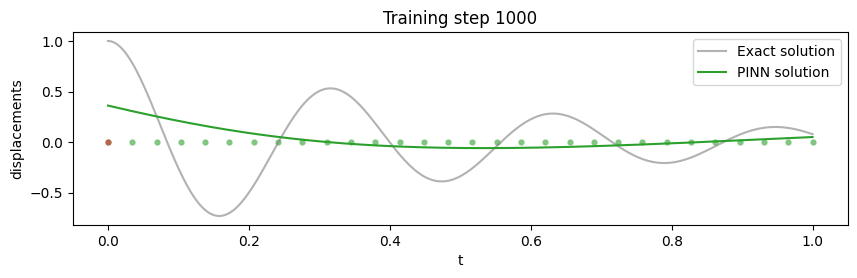

Saved the checkpoint corresponding to epoch: 1000
Decomposition of the loss terms: 
 loss(0.3705780506134033) = loss1(0.1733040064573288) + 0.0001 * loss2(23.658349990844727) + 0.0001 * loss3(1949.08203125)


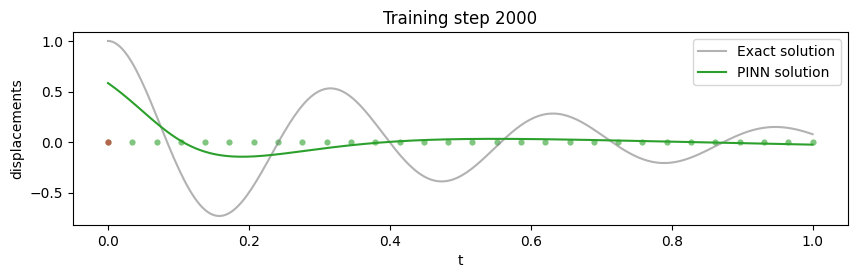

Saved the checkpoint corresponding to epoch: 2000
Training elapsed time using 1 GPU (s): 19.427595376968384


In [47]:
torch.manual_seed(123)

# define a neural network to train
#pinn_gpu = FCN(1,1,32,3) # N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYER
pinn_gpu = FCN_init(2,1,64,4, activation= "Tanh")

pinn_gpu.to(device)

# Define boundary points, for the boundary loss
t_boundary_gpu = torch.tensor(0.).view(-1,1).requires_grad_(True).to(device)
# Define training points over the entire domain, for the physics loss
t_physics_gpu = torch.linspace(0,1,30).view(-1,1).requires_grad_(True).to(device)
# Define temporal points for the test
t_test_gpu = torch.linspace(0,1,300).view(-1,1).to(device)

#Definition of the physical constants and hyperparameters:
d, w0 = 2, 20
mu, k = 2*d, w0**2
learning_rate_gpu =  1e-4         # learning rate
lambda1_gpu, lambda2_gpu = 1e-4, 1e-4 # loss term hyperparameters
epochs_gpu = 2000

# Calculation of the exact solution:
u_exact_gpu = exact_solution(d, w0, t_test_gpu)

# Definition of the optimizer:
optimiser_gpu = torch.optim.Adam(pinn_gpu.parameters(), lr= learning_rate_gpu)

# Creation of the variables loss1_history, loss2_history and loss3_history for printing the evolution of the contribution of every loss term:
loss1_history_gpu = []
loss2_history_gpu = []
loss3_history_gpu = []

# Starting training:
start_gpu = time.time()
for i in range(1, epochs_gpu+1):    
    #clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).
    optimiser_gpu.zero_grad() 

    # compute boundary loss
    u_boundary_gpu = pinn_gpu(t_boundary_gpu)
    loss1_gpu = (torch.squeeze(u_boundary_gpu) - 1)**2
    loss1_history_gpu.append(loss1_gpu.item())

    dudt_gpu = torch.autograd.grad(u_boundary_gpu, t_boundary_gpu, torch.ones_like(u_boundary_gpu), create_graph=True)[0]
    loss2_gpu = (torch.squeeze(dudt_gpu) - 0)**2
    loss2_history_gpu.append(loss2_gpu.item())

    # compute physics loss
    u_physics_gpu = pinn_gpu(t_physics_gpu)
    dudt_gpu = torch.autograd.grad(u_physics_gpu, t_physics_gpu, torch.ones_like(u_physics_gpu), create_graph=True)[0]
    d2udt2_gpu = torch.autograd.grad(dudt_gpu, t_physics_gpu, torch.ones_like(dudt_gpu), create_graph=True)[0]
    loss3_gpu = torch.mean((d2udt2_gpu + mu*dudt_gpu + k*u_physics_gpu)**2)
    loss3_history_gpu.append(loss3_gpu.item())

    # backpropagate joint loss, take optimiser step
    loss_gpu = loss1_gpu + lambda1_gpu*loss2_gpu + lambda2_gpu*loss3_gpu
    loss_gpu.backward() 
    optimiser_gpu.step()    
    
    # plot the result as training progresses
    if i % 1000 == 0: 
        #print(u_physics.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        print(f'Decomposition of the loss terms: \n loss({loss_gpu}) = loss1({loss1_gpu}) + {lambda1_gpu} * loss2({loss2_gpu}) + {lambda2_gpu} * loss3({loss3_gpu})')
        u_test_gpu = pinn_gpu(t_test_gpu).detach().cpu()
        plt.figure(figsize=(10,2.5))
        plt.scatter(t_physics_gpu.detach().cpu()[:,0], 
                    torch.zeros_like(t_physics_gpu).cpu()[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary_gpu.detach().cpu()[:,0], 
                    torch.zeros_like(t_boundary_gpu).cpu()[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test_gpu.cpu()[:,0], u_exact_gpu.cpu()[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test_gpu.cpu()[:,0], u_test_gpu.cpu()[:,0], label="PINN solution", color="tab:green")
        plt.scatter(
                   t_physics_gpu.detach().cpu()[:,0].detach().numpy(), 
                    torch.zeros_like(t_physics_gpu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:red",
                    alpha=0.6,
                    label= "Training points"
        )
        plt.scatter(
                    test_in_t_mu[0], 
                    torch.zeros_like(test_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:green",
                    alpha=0.6,
                    label= "Seed points(testing)"
        )
        plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), epoch = {i} \n (learning rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})")
        plt.xlabel("t")
        plt.ylabel("displacements")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.grid()
        plt.show()
        torch.save({
                    "epoch": i,
                    "model_state_dict": pinn_gpu.state_dict(),
                    "optimizer_state_dict": optimiser_gpu.state_dict(),
                    "loss": loss_gpu,
                   },                    
                    f"{learning_rate_gpu}_{i}.pth")
        print(f"Saved the checkpoint corresponding to epoch: {i}")
end_gpu = time.time()
execution_time_gpu = (end_gpu - start_gpu)
print(f"Training elapsed time using 1 GPU (s): {execution_time_gpu}")

In [48]:
i

2000

### Load the checkpoint:

In [49]:
pinn_gpu = FCN(1,1,32,3) # N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYER
pinn_gpu.to(device)
optimiser_gpu = torch.optim.Adam(pinn_gpu.parameters(), lr= learning_rate_gpu)

In [50]:
checkpoint = torch.load(f"{learning_rate_gpu}_{i}.pth")
pinn_gpu.load_state_dict(checkpoint["model_state_dict"])
optimiser_gpu.load_state_dict(checkpoint["optimizer_state_dict"])
epochs_gpu = checkpoint["epoch"]
loss_gpu = checkpoint["loss"]

In [51]:
checkpoint["epoch"]

2000

## Continue training:

In [52]:
# pinn_gpu.train() TESTTTTTT

In [53]:
epochs_delta = 2000 + epochs_gpu

Decomposition of the loss terms: 
 loss(0.37008336186408997) = loss1(0.17300255596637726) + 0.0001 * loss2(23.681962966918945) + 0.0001 * loss3(1947.1260986328125)


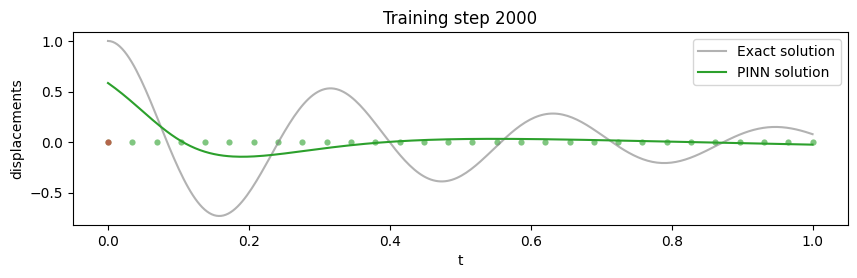

Saved the checkpoint corresponding to epoch: 2000
Decomposition of the loss terms: 
 loss(0.11406958848237991) = loss1(0.023784814402461052) + 0.0001 * loss2(16.10056495666504) + 0.0001 * loss3(886.7471923828125)


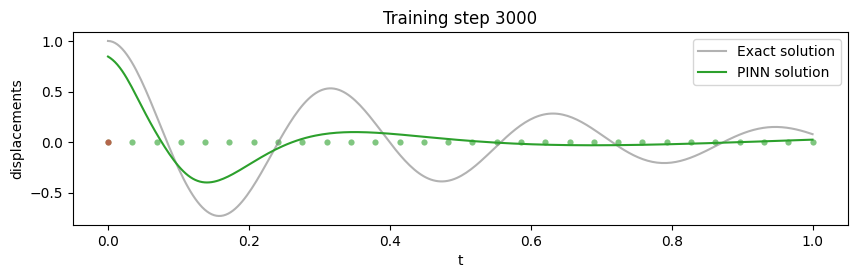

Saved the checkpoint corresponding to epoch: 3000
Decomposition of the loss terms: 
 loss(0.04141324758529663) = loss1(0.0028363957535475492) + 0.0001 * loss2(0.05613503232598305) + 0.0001 * loss3(385.71240234375)


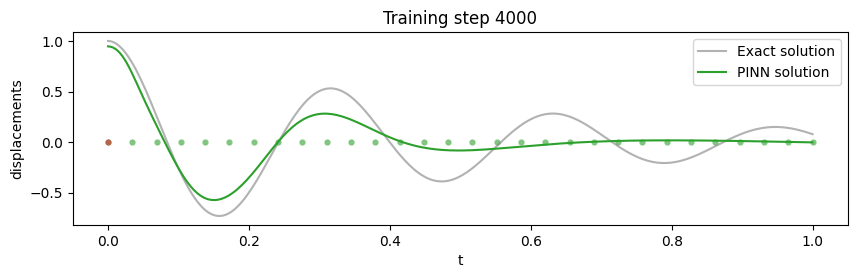

Saved the checkpoint corresponding to epoch: 4000


In [54]:
for i in range(epochs_gpu, epochs_delta+1):    
    #clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).
    optimiser_gpu.zero_grad() 

    # compute boundary loss
    u_boundary_gpu = pinn_gpu(t_boundary_gpu)
    loss1_gpu = (torch.squeeze(u_boundary_gpu) - 1)**2
    loss1_history_gpu.append(loss1_gpu.item())

    dudt_gpu = torch.autograd.grad(u_boundary_gpu, t_boundary_gpu, torch.ones_like(u_boundary_gpu), create_graph=True)[0]
    loss2_gpu = (torch.squeeze(dudt_gpu) - 0)**2
    loss2_history_gpu.append(loss2_gpu.item())

    # compute physics loss
    u_physics_gpu = pinn_gpu(t_physics_gpu)
    dudt_gpu = torch.autograd.grad(u_physics_gpu, t_physics_gpu, torch.ones_like(u_physics_gpu), create_graph=True)[0]
    d2udt2_gpu = torch.autograd.grad(dudt_gpu, t_physics_gpu, torch.ones_like(dudt_gpu), create_graph=True)[0]
    loss3_gpu = torch.mean((d2udt2_gpu + mu*dudt_gpu + k*u_physics_gpu)**2)
    loss3_history_gpu.append(loss3_gpu.item())

    # backpropagate joint loss, take optimiser step
    loss_gpu = loss1_gpu + lambda1_gpu*loss2_gpu + lambda2_gpu*loss3_gpu
    loss_gpu.backward() 
    optimiser_gpu.step()    
    
    # plot the result as training progresses
    if i % 1000 == 0: 
        #print(u_physics.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        print(f'Decomposition of the loss terms: \n loss({loss_gpu}) = loss1({loss1_gpu}) + {lambda1_gpu} * loss2({loss2_gpu}) + {lambda2_gpu} * loss3({loss3_gpu})')
        u_test_gpu = pinn_gpu(t_test_gpu).detach().cpu()
        plt.figure(figsize=(10,2.5))
        plt.scatter(t_physics_gpu.detach().cpu()[:,0], 
                    torch.zeros_like(t_physics_gpu).cpu()[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary_gpu.detach().cpu()[:,0], 
                    torch.zeros_like(t_boundary_gpu).cpu()[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test_gpu.cpu()[:,0], u_exact_gpu.cpu()[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test_gpu.cpu()[:,0], u_test_gpu.cpu()[:,0], label="PINN solution", color="tab:green")
        plt.xlabel("t")
        plt.ylabel("displacements")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()
        torch.save({
                    "epoch": i,
                    "model_state_dict": pinn_gpu.state_dict(),
                    "optimizer_state_dict": optimiser_gpu.state_dict(),
                    "loss": loss_gpu,
                   },                    
                    f"{learning_rate_gpu}_{i}.pth")
        print(f"Saved the checkpoint corresponding to epoch: {i}")

In [55]:
pinn_gpu.state_dict()

OrderedDict([('fcs.0.weight',
              tensor([[-0.6591],
                      [ 0.4151],
                      [-0.7408],
                      [ 0.7565],
                      [-1.1858],
                      [ 1.1031],
                      [-0.9715],
                      [-1.1474],
                      [-0.9598],
                      [ 0.8248],
                      [-0.7211],
                      [ 0.5642],
                      [-1.1899],
                      [-0.9117],
                      [-0.6901],
                      [-0.5329],
                      [-1.1266],
                      [ 1.0267],
                      [-0.3903],
                      [ 0.6160],
                      [ 1.0056],
                      [ 0.4839],
                      [ 0.6449],
                      [ 1.2977],
                      [-0.6239],
                      [ 0.0761],
                      [-0.7631],
                      [ 1.0541],
                      [ 1.1029],
             